<a href="https://colab.research.google.com/github/rradams/MUSA650_RemoteSensing_Final/blob/main/Adams_Tran_code_Urban_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classifying Urban Land in Indonesia Using Satellite Imagery**

Rebekah Adams and Tiffany M. Tran

Department of City and Regional Planning, University of Pennsylvania

MUSA 6500 Geospatial Machine Learning in Remote Sensing

Dr. Guray Erus

April 2023

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop # optimizer
import keras
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


# Set up functions

In [3]:
# Create function to plot confusion matrix
def plot_cm(model, test_data, title):
  predict_x = np.round(model.predict(test_data))
  cm = confusion_matrix(Y_test, predict_x)
  disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                                display_labels=categories)
  
  return(
      disp.plot(),
      disp.ax_.set_title(f"{title}")
  )

In [4]:
# Create function to plot ROC curve - how to make less angular?
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_set):
  predict_x=model.predict(test_set) # predictions with probabilities for each class, i.e. the best guess

  # Compute fpr, tpr, thresholds and roc auc
  fpr, tpr, thresholds = roc_curve(Y_test, predict_x)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  return(
      plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc),
      plt.plot([0, 1], [0, 1], 'k--'),  # random predictions curve
      plt.xlim([0.0, 1.0]),
      plt.ylim([0.0, 1.0]),
      plt.xlabel('False Positive Rate or (1 - Specifity)'),
      plt.ylabel('True Positive Rate or (Sensitivity)'),
      plt.title('Receiver Operating Characteristic'),
      plt.legend(loc="lower right")
  )


In [5]:
  # Plot images of False Positives - images that were predicted as Urban, but were actually Not Urban
  # This could help us identify areas of urban expansion

from mpl_toolkits.axes_grid1 import ImageGrid

def plot_false_positives(model, test_set):

    predict_x = np.round(model.predict(test_set))
    wrong_classifications = predict_x - Y_test # predicted classes - actual classes # classes_x
    wrong_classifications_index = np.array(np.where(wrong_classifications != 0))[:1,:] # index of where predictions were wrong
    wrong_predictions = predict_x[wrong_classifications_index] # use index to find wrong predictions # classes_x
    wrong_y_true = Y_test[wrong_classifications_index] # use index to find correct labels of wrong predictions
    wrong_x_true = X_test[wrong_classifications_index] # use index to find pixels of incorrectly-predicted images

    # Identify False Positive - true Not Urban, predicted as Urban
    FP_index = np.where(wrong_y_true == 0) # find labels Not Urban areas, i.e. the false positives (Non-Urban labelled as 0)
    FP_labels = wrong_y_true[FP_index]
    FP_images = wrong_x_true[FP_index]

    # Select random sample of images from false positive results
    index_list = []

    for i in range(0,4):
      random_index = np.random.choice(FP_labels.shape[0])
      index_list.append(random_index)

    # Use random index to select four random images
    image_1 = FP_images[index_list[0]].reshape(64,64,3)
    image_2 = FP_images[index_list[1]].reshape(64,64,3)
    image_3 = FP_images[index_list[2]].reshape(64,64,3)
    image_4 = FP_images[index_list[3]].reshape(64,64,3)

    # Plot
    fig = plt.figure() #figsize=(4., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, [image_1, image_2, image_3, image_4]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    return(grid.axes_all[1].set_title("Examples of False Positive Classifications - Predicted as Urban, but are officially not urban"))

In [6]:
# Function to plot accuracy and loss for each model
def plot_accuracy_and_loss(model_history):
  return(
    plt.plot(model_history.history['accuracy']),
    plt.plot(model_history.history['val_accuracy']),
    plt.title('model accuracy'),
    plt.ylabel('accuracy'),
    plt.xlabel('epoch'),
    plt.legend(['train', 'test'], loc='upper left'),
    plt.show(),

    plt.plot(model_history.history['loss']),
    plt.plot(model_history.history['val_loss']),
    plt.title('model loss'),
    plt.ylabel('loss'),
    plt.xlabel('epoch'),
    plt.legend(['train', 'test'], loc='upper left'),
    plt.show(),
  )

# Import images

In [7]:
# import images

import os
import skimage
from skimage import io
import numpy as np
from glob import glob
from pathlib import Path

raw_labels =[]
raw_images = []
raw_label_names = []
here = Path(os.getcwd())

for idx, directory in enumerate(sorted((here / "drive/MyDrive/MUSA650_RemoteSensing_Final/data/").glob("*"))):  # keep this line for running on colab
#for idx, directory in enumerate(sorted((here / "./data/cirebon").glob("*"))):  # Keep this line for running locally
    for img_path in directory.glob("*.jpg"):
        raw_labels.append(idx)
        raw_label_names.append(directory)
        raw_images.append(io.imread(img_path))
        
# convert to numpy arrays
images = np.array(raw_images)
images = images[:, :64, :64, :3] # trim extra pixel and alpha channel
labels = np.array(raw_labels)
label_names = np.array(raw_label_names)

In [8]:
# view label names
label_names

array([PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       ...,
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban')],
      dtype=object)

In [9]:
# confirm images are correctly labeled (not_urban = 0, urban = 1)
labels

array([0, 0, 0, ..., 1, 1, 1])

In [10]:
# Confrim the range of values in the dataset - yes, they are between 0 and 255
print("Max pixel value is: ", images.max())
print("Min pixel value is: ", images.min())

Max pixel value is:  255
Min pixel value is:  0


In [11]:
# Draw out just the urban images
urban_labels_index = np.where(labels == 1)
urban_labels = labels[urban_labels_index]
urban_images = images[urban_labels_index]

In [12]:
# Draw out just the non-urban images
non_urban_labels_index = np.where(labels == 0)
non_urban_labels = labels[non_urban_labels_index]
non_urban_images = images[non_urban_labels_index]

# Generate a random selection of non-urban images - the same number as urban images.
NU_labels_subset = []
NU_images_subset = []

for i in range(0, urban_labels.shape[0]):
  random_index_for_subset = np.random.choice(non_urban_labels.shape[0])
  subset_label = non_urban_labels[random_index_for_subset]
  subset_image = non_urban_images[random_index_for_subset]
  NU_labels_subset.append(subset_label)
  NU_images_subset.append(subset_image)

# Convert to numpy arrays
non_urban_images = np.array(NU_images_subset)
non_urban_labels = np.array(NU_labels_subset)

In [13]:
# Combine urban and non-urban images and labels - now we have equal numbers of urban and non-urban elements.
subset_images = np.concatenate((non_urban_images, urban_images), axis = 0)
subset_labels = np.concatenate((non_urban_labels, urban_labels), axis = 0)

Text(0.5, 1.0, 'Category is: Not Urban')

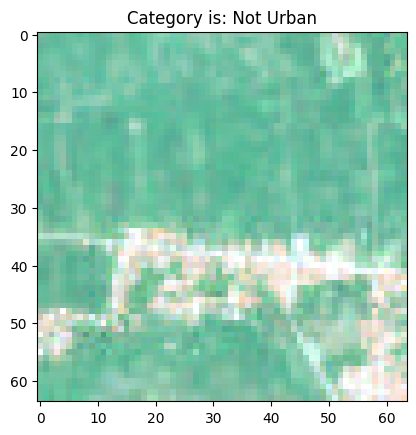

In [44]:
# Visualize Images - note, some categories are not visible due to channels selected
import matplotlib.pyplot as plt

random_index = np.random.choice(subset_labels.shape[0],1)
category_image = subset_images[random_index].reshape(64,64,3)
categories = ["Not Urban", "Urban"] # currently 1 = urban and 0 = not urban
plt.imshow(category_image)
plt.title(f"Category is: {categories[subset_labels[random_index][0]]}")

In [16]:
import sklearn

# split test and train data
from sklearn.model_selection import train_test_split 

# using the train test split function
(X_train, X_test, Y_train, Y_test) = train_test_split(subset_images, subset_labels,
                                                      stratify = subset_labels,
                                                        random_state=104, 
                                                        test_size=0.5, 
                                                        shuffle=True)

In [17]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=180
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [18]:
train_augmented = train_datagen.flow(
    x = X_train,
    y = Y_train,
    batch_size=100)

test_augmented = test_datagen.flow(
    x = X_test,
    y = Y_test,
    batch_size=100)

[86]


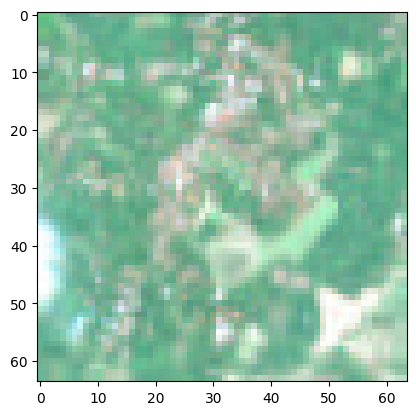

In [61]:
# Plot an example of an augmented image
for i in train_augmented:
  plt.imshow(i[0][12])
  break

# Model 1 - Self-Made CNN

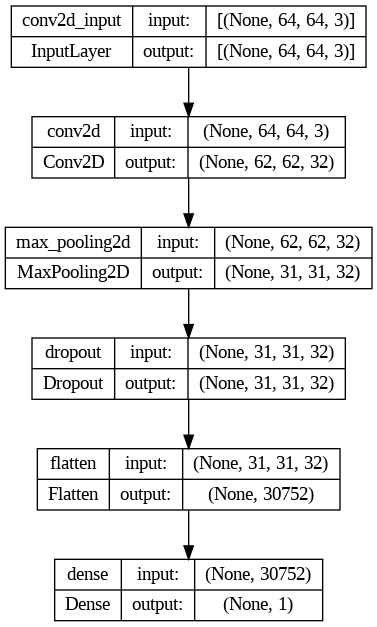

In [20]:
input_shape = (images.shape[1], images.shape[2], images.shape[3])
num_classes = 2

handmade_cnn = Sequential()
handmade_cnn.add(Conv2D(32, kernel_size=(3, 3), # Conv2D layer - apply 32 convolutions with a 3x3 kernel
                 activation='relu',
                 input_shape=input_shape))
handmade_cnn.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling 2D layer
handmade_cnn.add(Dropout(0.25)) # drop out
handmade_cnn.add(Flatten()) # flatten before putting into dense network
handmade_cnn.add(Dense(1, activation='sigmoid')) # dense layer 

# comment out summary for space
#handmade_cnn.summary()
plot_model(handmade_cnn, show_shapes=True, show_layer_names=True)

In [21]:
# compile model
handmade_cnn.compile(
    loss='binary_crossentropy',
    optimizer = "adam",
              metrics=['accuracy'])

history_handmade_cnn = handmade_cnn.fit(train_augmented, # training data
                    batch_size=100,
                    epochs=100,
                    verbose=1,
                    validation_data= (test_augmented))  # testing data


Epoch 1/100
2/2 [==============================] - 9s 383ms/step - loss: 1.5275 - accuracy: 0.4649 - val_loss: 0.7838 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 0s 58ms/step - loss: 0.8544 - accuracy: 0.4474 - val_loss: 0.9227 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 0s 163ms/step - loss: 0.8443 - accuracy: 0.5000 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 0s 54ms/step - loss: 0.7133 - accuracy: 0.4912 - val_loss: 0.7211 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 0s 175ms/step - loss: 0.7254 - accuracy: 0.5000 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 0s 60ms/step - loss: 0.7046 - accuracy: 0.5000 - val_loss: 0.6545 - val_accuracy: 0.7368
Epoch 7/100
2/2 [==============================] - 0s 162ms/step - loss: 0.6745 - accuracy: 0.5526 - val_loss: 0.6439 - val_accuracy: 0.5702
Epoch 8/100
2/2 

In [22]:
handmade_cnn_score = handmade_cnn.evaluate(X_test, Y_test, verbose=0) #Y_test_cat
accuracy_handmade_cnn = handmade_cnn_score[1]
print('Handmade Model accuracy:', round(accuracy_handmade_cnn, 3) * 100, "%")

Handmade Model accuracy: 75.4 %


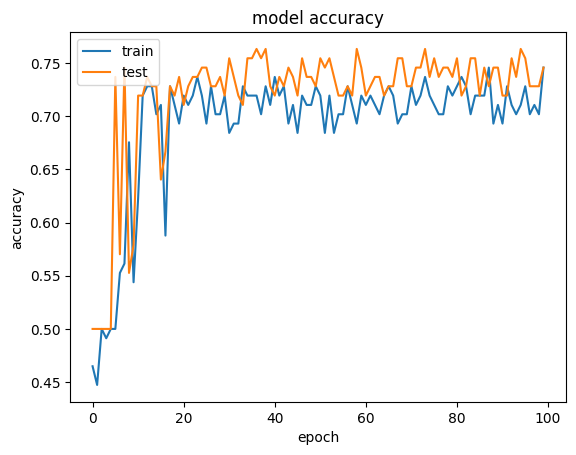

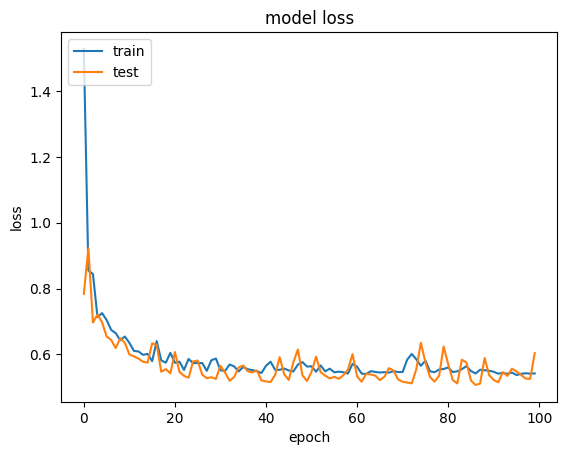

([<matplotlib.lines.Line2D at 0x7f4f602143d0>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [23]:
plot_accuracy_and_loss(history_handmade_cnn)

## Assess Accuracy

4/4 [==============================] - 0s 3ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4f60133340>,
 Text(0.5, 1.0, 'Confusion Matrix, Handmade Model'))

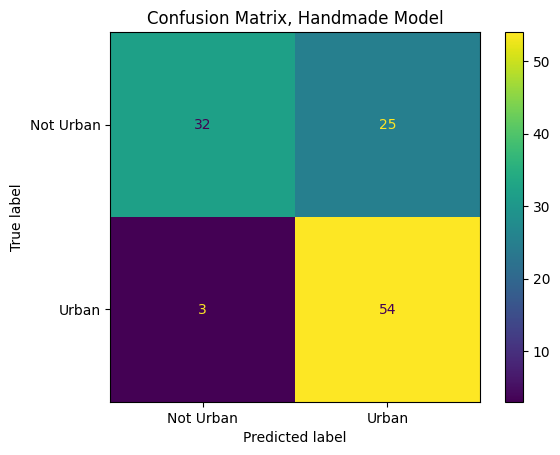

In [24]:
plot_cm(handmade_cnn, X_test, "Confusion Matrix, Handmade Model")

4/4 [==============================] - 0s 3ms/step


([<matplotlib.lines.Line2D at 0x7f4eec3b7d60>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f4eec3a3250>)

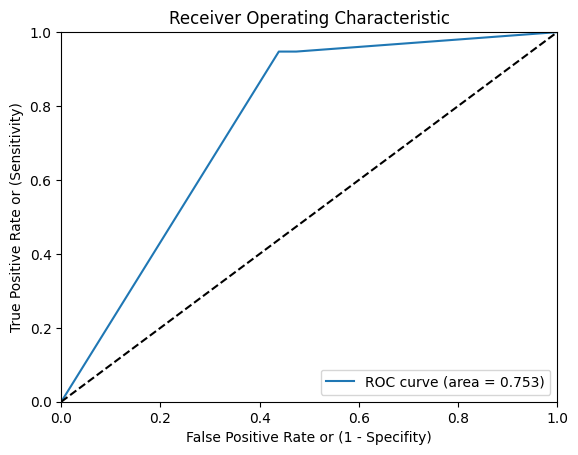

In [25]:
plot_roc_curve(handmade_cnn, X_test)

4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

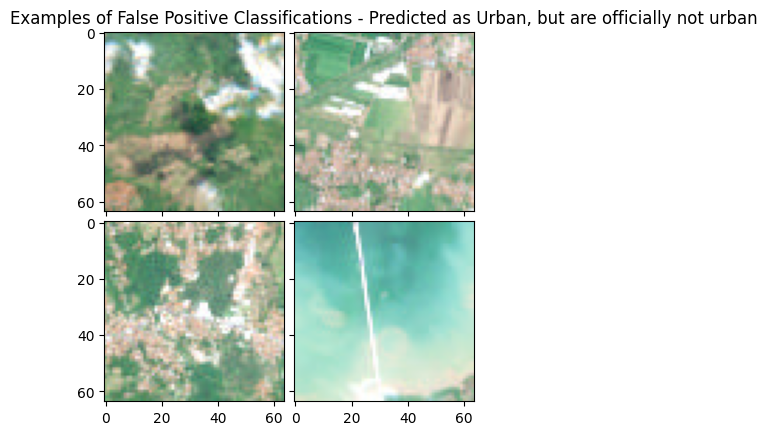

In [63]:
plot_false_positives(handmade_cnn, X_test)

# VGG-16

In [64]:
# load vgg model
from keras.applications.vgg16 import VGG16

# load the model
vgg16 = VGG16(weights='imagenet', include_top = False, input_shape=input_shape) # set VGG to trainable, set VGG to take images shaped as 64*64*3
#vgg16.summary()

# preprocess data for VGG16
from keras.applications.vgg16 import preprocess_input

X_train_vgg = preprocess_input(X_train) # normalize training data
X_test_vgg = preprocess_input(X_test) # normalize test data

# this is the augmentation configuration we will use for training
train_datagen_vgg = ImageDataGenerator(
    rotation_range=180
    )
    

# this is the augmentation configuration we will use for testing:
# (none, since vgg preprocessing already rescales images)
test_datagen_vgg = ImageDataGenerator()

# Augment data
train_augmented_vgg = train_datagen_vgg.flow(
    x = X_train_vgg,
    y = Y_train,
    batch_size=100)

test_augmented_vgg = test_datagen_vgg.flow(
    x = X_test_vgg,
    y = Y_test,
    batch_size=100)

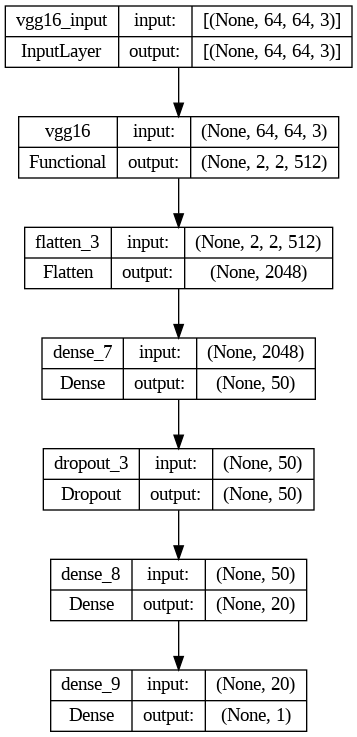

In [65]:
# Add last layers for our images
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
drop_out_layer = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

# set model architecture
vgg16_model = models.Sequential([
    vgg16,
    flatten_layer,
    dense_layer_1,
    drop_out_layer,
    dense_layer_2,
    prediction_layer
])

plot_model(vgg16_model, show_shapes=True, show_layer_names=True)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

vgg16_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# commenting out so it doesn't run accidentally - takes forever to run
history_vgg16 = vgg16_model.fit(train_augmented_vgg,
            epochs=100,
            validation_split=0.2,
            batch_size=100,
            callbacks=[es],
            validation_data=test_augmented_vgg)

Epoch 1/100
2/2 [==============================] - 6s 578ms/step - loss: 55.1590 - accuracy: 0.5175 - val_loss: 45.2905 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 0s 110ms/step - loss: 35.8975 - accuracy: 0.5175 - val_loss: 13.7120 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 0s 106ms/step - loss: 10.2195 - accuracy: 0.5351 - val_loss: 1.0988 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 0s 145ms/step - loss: 1.5475 - accuracy: 0.4825 - val_loss: 0.6759 - val_accuracy: 0.6404
Epoch 5/100
2/2 [==============================] - 0s 256ms/step - loss: 0.7423 - accuracy: 0.4474 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 0s 144ms/step - loss: 0.6981 - accuracy: 0.5702 - val_loss: 0.6785 - val_accuracy: 0.6667
Epoch 7/100
2/2 [==============================] - 0s 125ms/step - loss: 0.7129 - accuracy: 0.4737 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 8/

In [67]:
vgg16_model_score = vgg16_model.evaluate(X_test_vgg, Y_test, verbose=0)
accuracy_vgg16_model = vgg16_model_score[1]
print('VGG-16 Test accuracy:', round(accuracy_vgg16_model, 3) * 100, "%") 

VGG-16 Test accuracy: 66.7 %


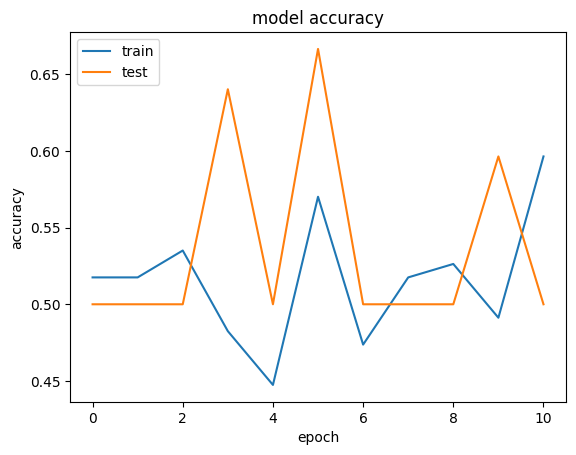

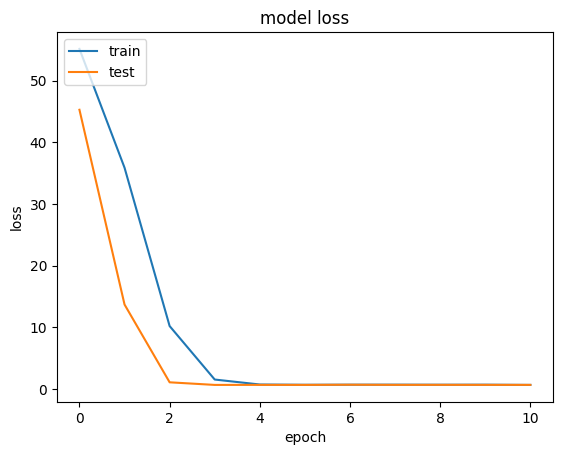

([<matplotlib.lines.Line2D at 0x7f4e40d9ac50>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [68]:
plot_accuracy_and_loss(history_vgg16)

4/4 [==============================] - 0s 11ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4e91f36650>,
 Text(0.5, 1.0, 'Confusion Matrix: VGG16'))

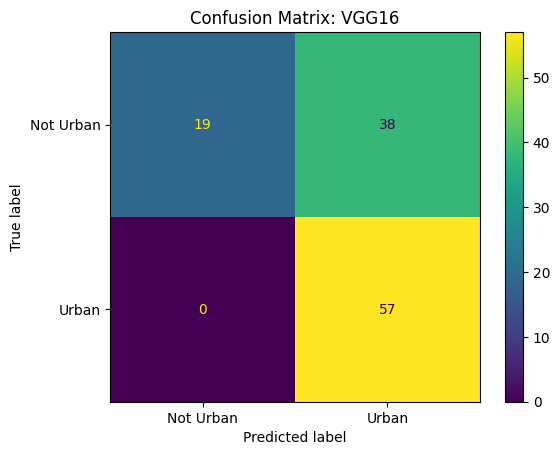

In [69]:
plot_cm(vgg16_model, X_test_vgg, "Confusion Matrix: VGG16")

4/4 [==============================] - 0s 11ms/step


([<matplotlib.lines.Line2D at 0x7f4e91e6f910>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f4e91e56c50>)

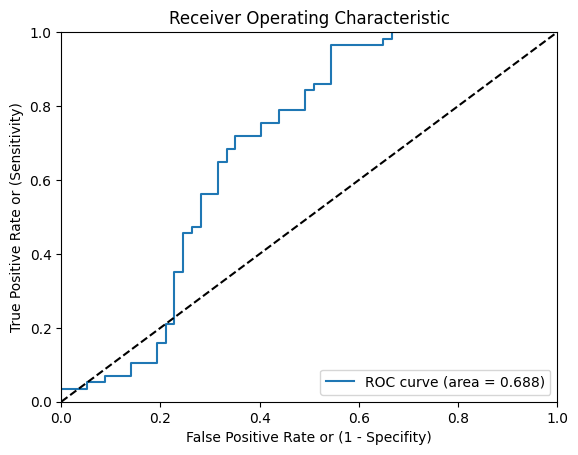

In [70]:
plot_roc_curve(vgg16_model, X_test_vgg)

4/4 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

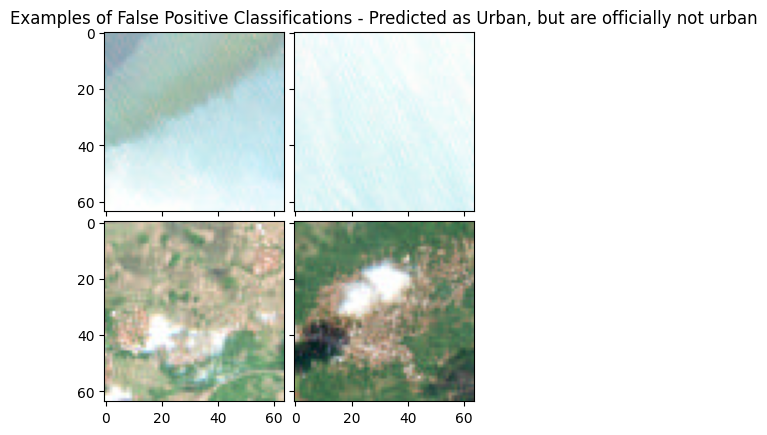

In [73]:
plot_false_positives(vgg16_model, X_test_vgg) # may not work if predicted no positives

# EfficientNet V2
https://arxiv.org/abs/2104.00298

In [35]:
# load model
from keras.applications.efficientnet_v2 import EfficientNetV2S

# load the model
eff_net = EfficientNetV2S(weights='imagenet', include_top = False, input_shape=input_shape) # set to trainable, set to take images shaped as 64*64*3
#eff_net.summary()

# preprocess data for EfficientNet
from keras.applications.efficientnet_v2 import preprocess_input

X_train_EN = preprocess_input(X_train) # normalize training data
X_test_EN = preprocess_input(X_test) # normalize test data


# this is the augmentation configuration we will use for training
train_datagen_EN = ImageDataGenerator(
    rotation_range=180
    )
    

# this is the augmentation configuration we will use for testing:
# (none, since EN preprocessing already rescales images)
test_datagen_EN = ImageDataGenerator()


# Augment data
train_augmented_EN = train_datagen_EN.flow(
    x = X_train_EN,
     y = Y_train,
     batch_size=100)

test_augmented_EN = test_datagen_EN.flow(
    x = X_test_EN,
    y = Y_test,
    batch_size=100)

82420632/82420632 [==============================] - 5s 0us/step


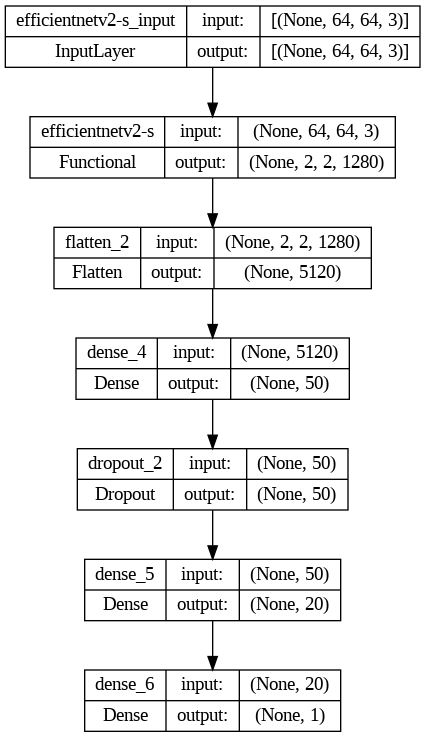

In [36]:
# Add last layers for our images

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
drop_out_layer = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

# set model architecture
efficient_net_model = models.Sequential([
    eff_net,
    flatten_layer,
    dense_layer_1,
    drop_out_layer,
    dense_layer_2,
    prediction_layer
])

plot_model(efficient_net_model, show_shapes=True, show_layer_names=True)

In [37]:
# Compile
efficient_net_model.compile(
    optimizer='adam',
    #loss='categorical_crossentropy',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# Train
history_efficient_net = efficient_net_model.fit(train_augmented_EN, #X_train_EN,
            #Y_train_cat,
            epochs=100,
            validation_split=0.2,
            batch_size=100,
            callbacks=[es],
            validation_data=test_augmented_EN)

Epoch 1/100
2/2 [==============================] - 98s 6s/step - loss: 0.7071 - accuracy: 0.5351 - val_loss: 0.6675 - val_accuracy: 0.5877
Epoch 2/100
2/2 [==============================] - 0s 264ms/step - loss: 0.5799 - accuracy: 0.6754 - val_loss: 0.6353 - val_accuracy: 0.5877
Epoch 3/100
2/2 [==============================] - 1s 415ms/step - loss: 0.5491 - accuracy: 0.6754 - val_loss: 0.6159 - val_accuracy: 0.6140
Epoch 4/100
2/2 [==============================] - 0s 202ms/step - loss: 0.4449 - accuracy: 0.8070 - val_loss: 0.6480 - val_accuracy: 0.5526
Epoch 5/100
2/2 [==============================] - 0s 194ms/step - loss: 0.4385 - accuracy: 0.8333 - val_loss: 0.6485 - val_accuracy: 0.5789
Epoch 6/100
2/2 [==============================] - 0s 192ms/step - loss: 0.4437 - accuracy: 0.8070 - val_loss: 0.6241 - val_accuracy: 0.6140
Epoch 7/100
2/2 [==============================] - 1s 425ms/step - loss: 0.4248 - accuracy: 0.7632 - val_loss: 0.5984 - val_accuracy: 0.6404
Epoch 8/100
2/2

In [38]:
efficient_net_model_score = efficient_net_model.evaluate(X_test_EN, Y_test, verbose=0)
accuracy_eff_net = efficient_net_model_score[1]
print('EfficientNetV2 Test accuracy:', round(accuracy_eff_net, 3) * 100, "%") 

EfficientNetV2 Test accuracy: 72.8 %


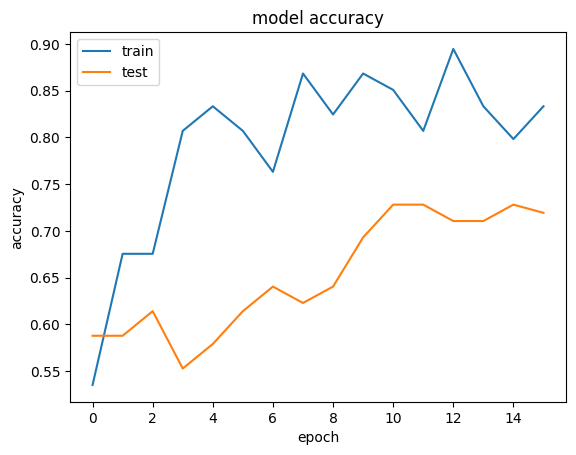

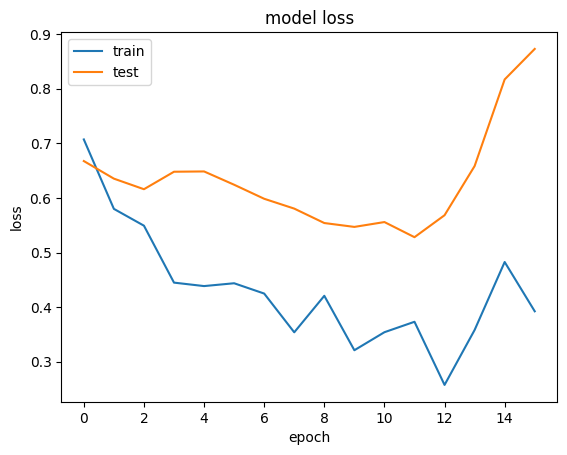

([<matplotlib.lines.Line2D at 0x7f4ea8bc39a0>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [39]:
plot_accuracy_and_loss(history_efficient_net)

4/4 [==============================] - 3s 37ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4ea8aa3910>,
 Text(0.5, 1.0, 'Confusion Matrix, EfficicentNetV2'))

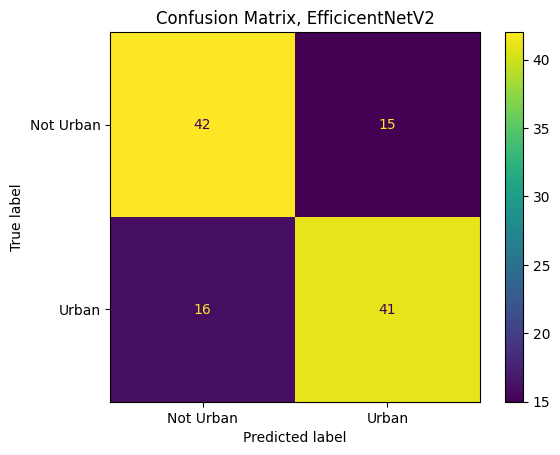

In [40]:
plot_cm(efficient_net_model, X_test_EN, "Confusion Matrix, EfficicentNetV2")

4/4 [==============================] - 0s 27ms/step


([<matplotlib.lines.Line2D at 0x7f4e9176a4a0>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f4ec6104790>)

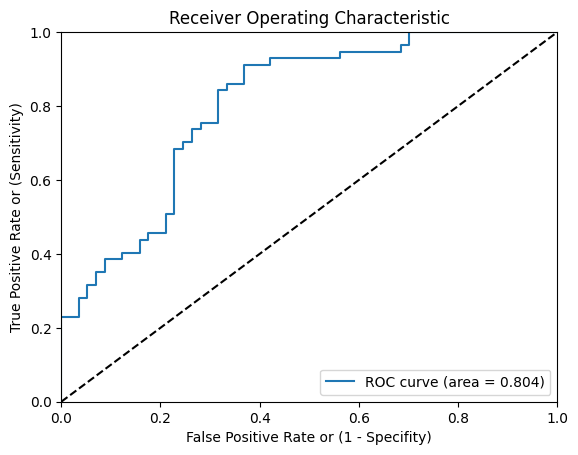

In [41]:
plot_roc_curve(efficient_net_model, X_test_EN)

4/4 [==============================] - 0s 35ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

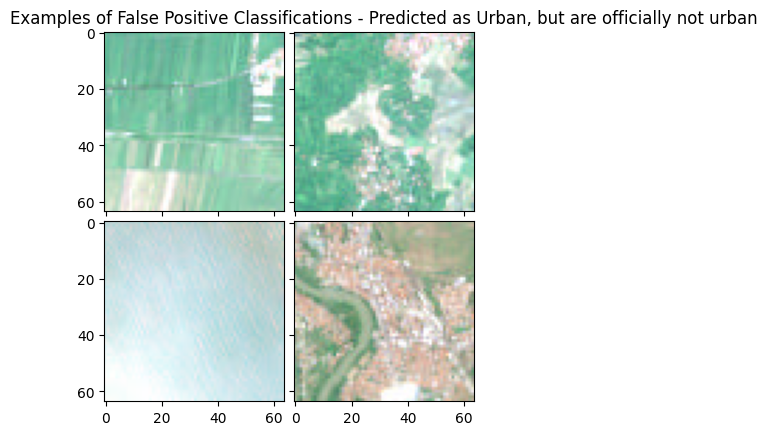

In [77]:
plot_false_positives(efficient_net_model, X_test_EN)